In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.layers import Dense, SimpleRNN, Input, Dropout
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
df = pd.read_csv('../data/update/data_update.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
inp_chars = 15
n = df.shape[0] - inp_chars

X = np.array([df[i:i+inp_chars] for i in range(n)])
y = df.iloc[inp_chars: ,0].to_numpy()

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

In [5]:
model = Sequential()
model.add(Input((inp_chars, 1)))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 41473 (162.00 KB)
Trainable params: 41473 (162.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

In [7]:
mlflow.set_experiment(experiment_name='Simple_RNN')

with mlflow.start_run(run_name='keras_2'):
    mlflow.keras.autolog()
    result = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_test, y_test), shuffle=False)

2023/10/24 13:28:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/15
2934/2934 [==============================] - 33s 11ms/step - loss: 0.8043 - root_mean_squared_error: 0.8968 - val_loss: 0.6439 - val_root_mean_squared_error: 0.8024
Epoch 2/15
2934/2934 [==============================] - 32s 11ms/step - loss: 0.7888 - root_mean_squared_error: 0.8882 - val_loss: 0.6464 - val_root_mean_squared_error: 0.8040
Epoch 3/15
2934/2934 [==============================] - 30s 10ms/step - loss: 0.7854 - root_mean_squared_error: 0.8862 - val_loss: 0.6540 - val_root_mean_squared_error: 0.8087
Epoch 4/15
2934/2934 [==============================] - 28s 9ms/step - loss: 0.7821 - root_mean_squared_error: 0.8844 - val_loss: 0.6522 - val_root_mean_squared_error: 0.8076
Epoch 5/15
2934/2934 [==============================] - 27s 9ms/step - loss: 0.7803 - root_mean_squared_error: 0.8834 - val_loss: 0.6524 - val_root_mean_squared_error: 0.8077
Epoch 6/15
2934/2934 [==============================] - 28s 9ms/step - loss: 0.7794 - root_mean_squared_error: 0.8828 - va

INFO:tensorflow:Assets written to: C:\Users\tolya\AppData\Local\Temp\tmpsiv7xqb7\model\data\model\assets
2023/10/24 13:36:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\tolya\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [8]:
def northern_lights(model, data, day=7):
    '''
    Предсказывает kp индекс на несколько дней вперёд 
    '''
    n_sample = day*8 
    df = data.tail(inp_chars).copy()
    
    for _ in range(n_sample):
        features = np.array(df.tail(inp_chars)).reshape(-1, inp_chars, 1)
        answer = model.predict(features, verbose=0).reshape(-1)
        df_2 = pd.DataFrame({'kp': answer}, index=df.tail(1).index + pd.DateOffset(hours=3))
        df = pd.concat([df, df_2], axis=0)

    return df

In [9]:
test_answer = northern_lights(model, df)

<AxesSubplot: xlabel='datetime'>

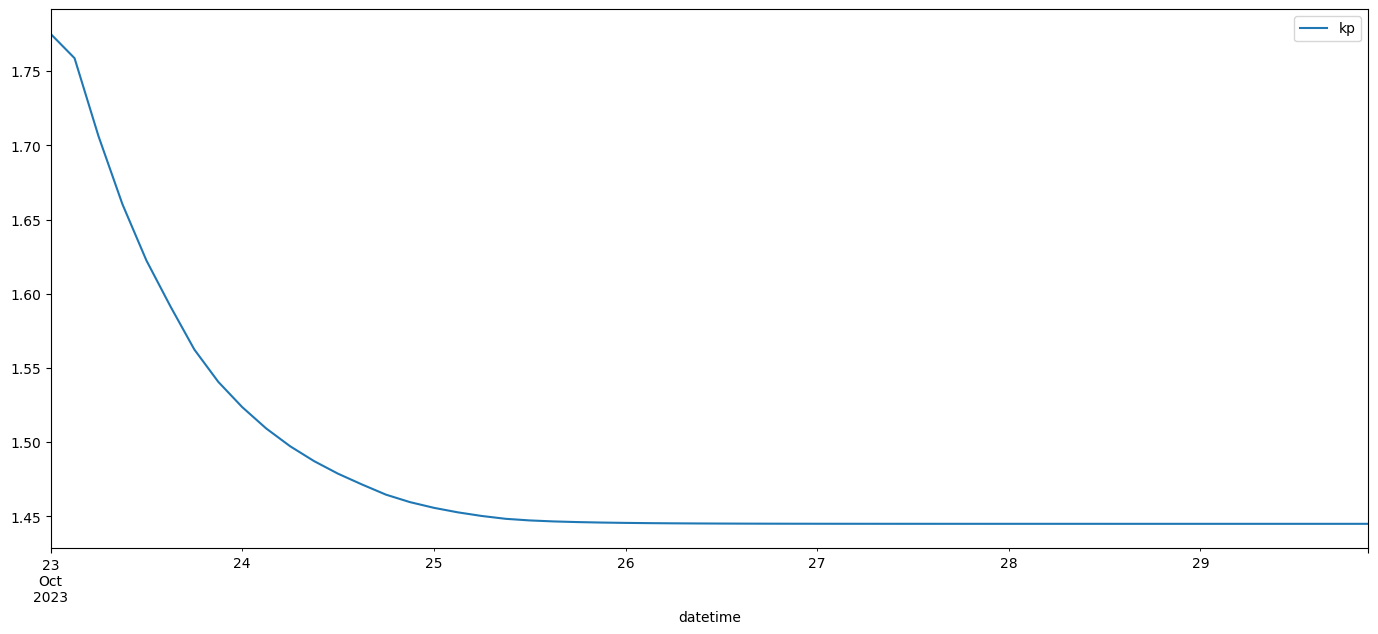

In [10]:
test_answer.iloc[-56:].plot(figsize=(17,7))